In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [29]:
RANDOM_SEED = 42

In [30]:
dataset = "C:\\Users\\anubh\Desktop\Hand gesture recognition\hand gesture recognition with mediapipe\datasets\point_history.csv"
model_save_path = "C:\\Users\\anubh\Desktop\Hand gesture recognition\hand gesture recognition with mediapipe\models\point_history_classifier.keras"
tflite_save_path = "C:\\Users\\anubh\Desktop\Hand gesture recognition\hand gesture recognition with mediapipe\models\point_history_classifier_tf.tflite"

In [31]:
num_classes = 4

In [32]:
time_steps = 16
dimensions = 2

In [33]:
x_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (time_steps * dimensions) + 1)))

In [34]:
y_dataset = np.loadtxt(dataset, delimiter = ',', dtype = 'int32', usecols=(0))

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset,  train_size = 0.75, random_state = RANDOM_SEED)

In [40]:
model = keras.models.Sequential([
    layers.InputLayer(input_shape = (time_steps* dimensions,)),
    layers.Reshape((time_steps, dimensions), input_shape = (time_steps, dimensions,)),
    layers.Dropout(0.2),
    layers.LSTM(16, input_shape = [time_steps, dimensions]),
    layers.Dropout(0.5),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(num_classes, activation = "softmax")
])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 16, 2)             0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 2)             0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                1216      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1556 (6.08 KB)
Trainable params: 1556 (6

In [42]:
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose = 1, save_weights_only = False)
es_callback = keras.callbacks.EarlyStopping(patience = 30, verbose = 1)
Callbacks = [cp_callback, es_callback]

In [43]:
model.compile(
    optimizer = "rmsprop",
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy'],
)

In [44]:
model.fit(x_train,
          y_train,
          epochs = 1000,
          batch_size = 64,
          validation_data = (x_test, y_test),
          callbacks = Callbacks,
         )        

Epoch 1/1000


61/63 [============================>.] - ETA: 0s - loss: 1.3856 - accuracy: 0.2754
Epoch 1: saving model to C:\Users\anubh\Desktop\Hand gesture recognition\hand gesture recognition with mediapipe\models\point_history_classifier.keras
63/63 [==============================] - 4s 21ms/step - loss: 1.3855 - accuracy: 0.2764 - val_loss: 1.3798 - val_accuracy: 0.2983
Epoch 2/1000
61/63 [============================>.] - ETA: 0s - loss: 1.3798 - accuracy: 0.2892
Epoch 2: saving model to C:\Users\anubh\Desktop\Hand gesture recognition\hand gesture recognition with mediapipe\models\point_history_classifier.keras
63/63 [==============================] - 1s 10ms/step - loss: 1.3797 - accuracy: 0.2895 - val_loss: 1.3731 - val_accuracy: 0.3331
Epoch 3/1000
62/63 [============================>.] - ETA: 0s - loss: 1.3659 - accuracy: 0.3528
Epoch 3: saving model to C:\Users\anubh\Desktop\Hand gesture recognition\hand gesture recognition with mediapipe\models\point_history_classifier.ker

In [45]:
val_loss ,val_acc  = model.evaluate(x_test, y_test, batch_size = 64)

21/21 [==============================] - 0s 3ms/step - loss: 0.0600 - accuracy: 0.9819


In [46]:
#98.19% accuracy lmao

In [47]:
model = keras.models.load_model(model_save_path)

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


42/42 [==============================] - 1s 3ms/step


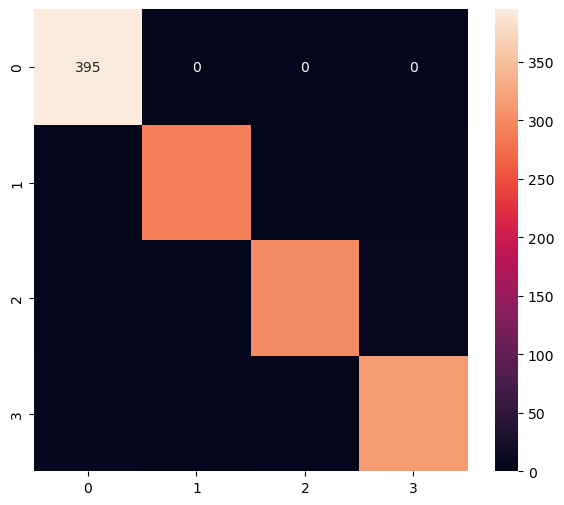

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       1.00      0.98      0.99       295
           2       0.99      0.98      0.98       307
           3       0.96      0.97      0.96       327

    accuracy                           0.98      1324
   macro avg       0.98      0.98      0.98      1324
weighted avg       0.98      0.98      0.98      1324



In [49]:
def print_confusion_matrix(y_true, y_pred, report = True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred,labels = labels)

    df_cmx = pd.DataFrame(cmx_data, index = labels, columns = labels)
    fig, ax = plt.subplots(figsize =(7,6))
    sns.heatmap(df_cmx, annot= True, fmt= 'g', square = False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis = 1)

print_confusion_matrix(y_test, y_pred)

In [50]:

model.save(model_save_path)

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_quantized_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\anubh\AppData\Local\Temp\tmpr_y9vt00\assets


INFO:tensorflow:Assets written to: C:\Users\anubh\AppData\Local\Temp\tmpr_y9vt00\assets


In [58]:
open(tflite_save_path, 'wb').write(tflite_quantized_model)

14040